# Samenhang

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.cm as cm
import statistics

missing_values = ['n/a', 'na', 'nan', 'N/A', 'NA', 'NaN', 'NAN', '--', 'Missing', 'missing', 'MISSING', 'Unknown',
                  'Weet ik niet', 'None', 'ONBEKEND', '"ontbrekend"', '"onbekend"', 'onbekend']

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score as r2score
class GeneralRegression:
    def __init__(self, degree=1, exp=False, log=False):
        self.degree = degree
        self.exp = exp
        self.log = log
        self.model = None
        self.x_orig = None
        self.y_orig = None
        self.X = None
        self.y = None

    def fit(self, x: np.array, y: np.array):
        self.x_orig = x
        self.y_orig = y
        self.X = x.reshape(-1, 1)

        if self.exp:
            self.y = np.log(y)

        else:
            self.y = y

        if self.log:
            self.X = np.log(self.X)

        self.model = make_pipeline(PolynomialFeatures(degree=self.degree), LinearRegression())
        self.model.fit(self.X, self.y)

    def predict(self, x: np.array):
        X = x.reshape(-1, 1)

        if self.exp:
            return np.exp(self.model.predict(X))

        if self.log:
            return self.model.predict(np.log(X))

        return self.model.predict(X)

    @property
    def r2_score(self):
        return r2score(self.y_orig, self.predict(self.x_orig))

    @property
    def se_(self):
        if self.exp:
            return mean_squared_error(self.predict(self.X), np.exp(self.y), squared=False)
        if self.log:
            return mean_squared_error(self.predict(self.X), np.log(self.y), squared=False)
        return mean_squared_error(self.predict(self.X), self.y, squared=False)

    @property
    def coef_(self):
        return self.model.steps[1][1].coef_

    @property
    def intercept_(self):
        return self.model.steps[1][1].intercept_

In [60]:
def outlier_boundaries(x, factor=1.5):
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    I = Q3 - Q1
    return [Q1 - factor * I, Q3 + factor * I]


def drop_outliers(df, row):
    df['Z-Score'] = np.abs((df[row] - df[row].mean()) / df[row].std())
    filtered_df = df[df['Z-Score'] <= 3]
    filtered_df = filtered_df.drop('Z-Score', axis=1)
    return filtered_df


def aantal_klassen(series):
    n = len(series)
    print("Sturges (# klassen): " + str(math.ceil(1 + math.log2(n))))  # Sturges
    b = 3.5 * statistics.stdev(series) / (n ** (1 / 3))
    print("Scott (klasse breedte): " + str(math.ceil((series.max() - series.min()) / b)))  # Scott
    print("Scott (# klassen): " + str(math.ceil(math.sqrt(n))))
    print("[√n]: " + str(math.ceil(math.sqrt(n))))


def kendall(x, y):
    x = x.rank()
    y = y.rank()
    n = len(x)
    aantal = 0

    for i in range(1, n - 1):
        for j in range(i + 1, n):
            aantal = aantal + np.sign(x[i] - x[j]) * np.sign(y[i] - y[j])

    return 2 * aantal / (n / (n - 1))


def makescatter(x, y):
    plt.scatter(x, y)
    plt.xlabel(x.name)
    plt.ylabel(y.name)
    plt.show()

def scatterWhitReg(X,y,se=0): #model moet aanwezig zijn
    fig, ax = plt.subplots()
    _ = ax.scatter(X, y)
    xx = np.arange(X.min(), X.max(), (X.max() - X.min()) / 100)
    yy = model.predict(xx.reshape(-1, 1))
    _ = ax.fill_between(xx, yy - se, yy + se, color="yellow", alpha=0.2)
    _ = ax.plot(xx, yy, color='red')
    _ = ax.set_xlabel(X.name)
    _ = ax.set_ylabel(y.name)
    plt.show()

## Productiefouten batterijen
In een fabriek worden batterijen voor smartphones gefabriceerd. De vraag naar deze batterijen varieert
nogal sterk. Men heeft het vermoeden dat als de vraag (en dus ook de productie) stijgt, het percentage
ontploffende batterijen ook stijgt (en dus: de kwaliteit daalt onder de werkdruk). Dit wil men verifiëren.
Er wordt een meting gedaan. Iedere dag wordt het aantal geproduceerde batterijen bijgehouden. Als er een
defecte batterij terug wordt gebracht (of er een ontploft), wordt nagegaan op welke dag deze geproduceerd
werd. De data vind je terug in het bestand "batterijen.csv".
De eerste kolom geeft weer hoeveel er geproduceerd werd en de tweede kolom laat zien hoeveel batterijen
er defect waren.

1. Lees het bestand in. Er zijn lijnen met meer dan 2 waarden. Bekijk wat Python hiermee doet als je
de waarden inleest. Verwijder deze lijnen uit de data. Er zijn uitschieters in de kolom aantalDefect.
Verwijder deze. Hoeveel rijen hou je nu over?

In [31]:
df = pd.read_csv("./data/batterijen.csv", header=0, sep=",", decimal=".", na_values=missing_values)
outliers_defect = outlier_boundaries(df.aantalDefect)
# outliers_geproduceerd = outlier_boundaries(df.geproduceerd)

# # Filter de rijen met uitschieters
df = df[(df["aantalDefect"] >= outliers_defect[0]) & (df["aantalDefect"] <= outliers_defect[1])]
# df = df[(df["geproduceerd"] >= outliers_geproduceerd[0]) & (df["geproduceerd"] <= outliers_geproduceerd[1])]

df.dropna(inplace=True)
print(len(df))

93


2. Maak een scatterplot van de twee variabelen. Is er een lineair verband?

Er is geen lineair verband. De punten liggen op een kromme. We mogen hier dus geen lineaire regressie op toepassen.


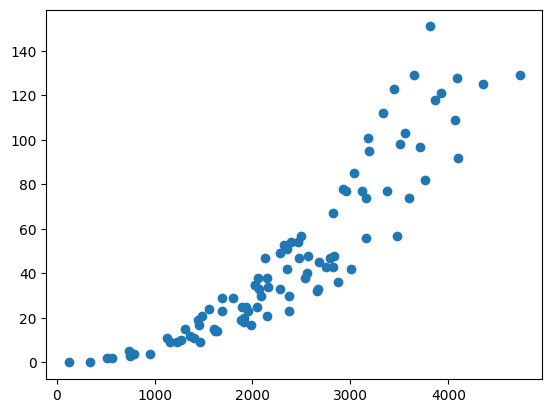

In [33]:
fig, ax = plt.subplots()
ax.scatter(df.geproduceerd, df.aantalDefect)

print(
    "Er is geen lineair verband. De punten liggen op een kromme. We mogen hier dus geen lineaire regressie op toepassen.")

3. Welke correlatie vind je met de methode van Kendall?

In [35]:
print(f"Correlatie methode Kendall: {df.geproduceerd.corr(df.aantalDefect, method='kendall').round(4)}")

Correlatie methode Kendall: 0.814


4. Eigenlijk zijn we niet geïnteresseerd in het absolute aantal defecte batterijen, maar wel in het
percentage. Deel dus het aantal defecte door het aantal geproduceerde batterijen. Wat is het
gemiddeld percentage defecte batterijen?

In [37]:
print(f"Gemiddeld percentage defecte batterijen: {(df.aantalDefect.sum() / df.geproduceerd.sum()) * 100}%")

Gemiddeld percentage defecte batterijen: 2.005238953480454%


5. Maak terug een scatterplot met het percentage defecte batterijen. Zie je het verschil met de vorige
grafiek?

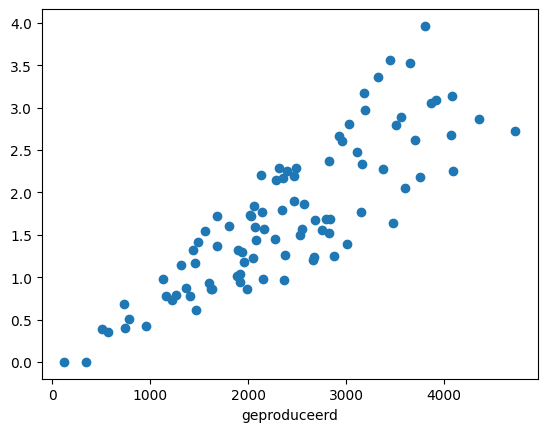

De punten liggen niet meer op een kromme maar vormen meer een wolk die van links onder naar rechts boven gaat


In [44]:
makescatter(df.geproduceerd, (df.aantalDefect / df.geproduceerd) * 100)
print("De punten liggen niet meer op een kromme maar vormen meer een wolk die van links onder naar rechts boven gaat")

6. Bereken nu de correlatie tussen het aantal geproduceerde batterijen en het percentage defecte
batterijen. Wat besluit je?

In [52]:
print(f"Correlatie tussen variabelen: {df.geproduceerd.corr(df.aantalDefect / df.geproduceerd) * 100}")

Correlatie tussen variabelen: 85.03092015597007


7. Wat is de waarde van R²? Wat betekent dit?

In [58]:
model = GeneralRegression(degree=1)
model.fit(df.geproduceerd.to_numpy(), ((df.aantalDefect / df.geproduceerd) * 100).to_numpy())
print(model.r2_score)

print("Dit wil zeggen dat 73,30% van de fouten dus door het tempo van de productie komt.")

0.7230257382570956
Dit wil zeggen dat 73,30% van de fouten dus door het tempo van de productie komt.


8. Teken de regressielijn bij de scatterplot. Wat zijn de waarden voor slope en intercept?

-0.05587171250994416
0.0007439079104402141


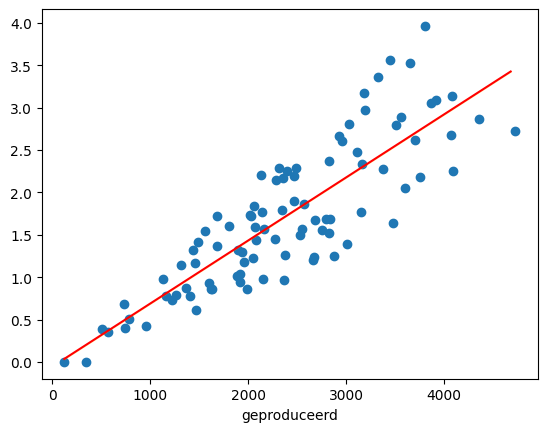

In [62]:
print(model.intercept_) # Intercept
print(model.coef_[1]) # Slope

scatterWhitReg(df.geproduceerd, (df.aantalDefect / df.geproduceerd) * 100)

9. Wat is de standaardschattingsfout? Wat betekent dit?

In [65]:
print(model.se_)
print("Hoe kleiner de waarde, hoe beter de lijn erdoor gaat. Men noemt deze waarde de “standaard schattingsfout\n"
      "De gevonden lijn zit dus gemiddeld 0,45% naast de echte waarde")

0.44934746067827963
Hoe kleiner de waarde, hoe beter de lijn erdoor gaat. Men noemt deze waarde de “standaard schattingsfout
De gevonden lijn zit dus gemiddeld 0,45% naast de echte waarde


10. Als de productie opgedreven zou worden tot 8000 batterijen/dag. Hoeveel defecte batterijen zou je
dan verwachten?

In [68]:
print(model.predict(np.array([8000])))
print("We verwachten dus 5,9% defecte kaarten.")

[5.89539157]
We verwachten dus 5,9% defecte kaarten.
